In [1]:
import json
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RBFInterpolator
from scipy import optimize
from bmn.brezin import compute_Brezin_energy

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["lines.linewidth"] = 2
plt.rc("font", family="serif", size=16)
matplotlib.rc("text", usetex=True)
matplotlib.rc("legend", fontsize=16)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
)
matplotlib.rcParams.update(
    {"axes.grid": True, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [78]:
def load_data(
        datadir,
        names_in_filename,
        tol=1e-6,
        ):

    # grab the data files
    names_in_filename.append('.json')
    files = []
    for f in os.listdir(datadir):
        if all(name in f for name in names_in_filename):
            files.append(f)
    print(f"number of files found: {len(files)}")

    # build dataframe
    data = []
    for file in files:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        #result["energy"] = float(file.split('_')[1][:-5]) # add g4 coupling
        result["filename"] = file
        if result["max_quad_constraint_violation"] < tol:
            data.append(result)
    df = pd.DataFrame(data)
    df.sort_values("energy", inplace=True)

    max_violation_linear = df["violation_of_linear_constraints"].max()
    max_violation_quadratic = df["max_quad_constraint_violation"].max()
    max_violation_PSD = df["min_bootstrap_eigenvalue"].abs().max()

    print(f"number of loaded data points: {len(data)}")
    print(f"max violation of linear constraints:{max_violation_linear:.4e}")
    print(f"max violation of PSD constraints:{max_violation_PSD:.4e}")
    print(f"max violation of quadratic constraints:{max_violation_quadratic:.4e}\n")

    return df.copy()

## Miscellaneous

In [ ]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]
d = 2

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 4)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-o', label="$n(2L)$", color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"count")
ax.legend()
#    ax.set_title(f"Growth of operators for d={d}")
ax.set_yscale('log')
plt.show()

## One Matrix

In [ ]:
data = []
for L in [3, 4]:
    path =f"data/OneMatrix_L_{L}"
    files = [f for f in os.listdir(path) if ".json" in f]
    print(f"L={L}, number of data points found: {len(files)}")

    for file in files:
        with open(f"{path}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        if result["max_quad_constraint_violation"] < 1e-2:
            result["L"] = int(L)
            result["g2"] = float(file.split('_')[1])
            result["g4"] = float(file.split('_')[3])
            result["g6"] = float(file.split('_')[5][:-5])
            data.append(result)

df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(10)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for L in [3, 4]:
    for g2 in [1]:

        df2 = df[(df["g6"] == 0) & (df["g2"] == g2) & (df["L"] == L)].sort_values("g4")
        g4_max = df2["g4"].max()
        g4_list = np.linspace(0.1, g4_max, 100)

        ax[0].scatter(df2["g4"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")
        ax[0].set_xlabel(r"$g_4$")
        ax[0].set_ylabel(r"$E/N^2$")

        ax[1].scatter(df2["g4"], df2["x_2"], edgecolors="k")
        ax[1].set_xlabel(r"$g_4$")
        ax[1].set_ylabel(r"tr$(X^2)$")

        ax[2].scatter(df2["g4"], df2["p_2"], edgecolors="k")
        ax[2].set_xlabel(r"$g_4$")
        ax[2].set_ylabel(r"tr$(P^2)$")

ax[0].plot(
    g4_list,
    [compute_Brezin_energy(g/4) for g in g4_list],
    '--',
    color='k',
    alpha=0.75,
    label=r"$g_2 = 1$ analytic"
    )

#[ax[i].set_xlim([0, 1.02 * g4_max]) for i in range(3)]
ax[0].legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["g6"] == 0) & (df["g2"] == 1) & (df["L"] == L)].sort_values("g4")
    Brezin_energy = np.asarray([compute_Brezin_energy(g/4) for g in df2["g4"]])
    ax.scatter(df2["g4"], np.abs(Brezin_energy - df2["energy"]), edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$|\Delta E|/N^2$")
ax.legend(frameon=False)
ax.set_yscale('log')
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["L"] == L)].sort_values("g4")
    ax.scatter(df2["g6"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
df2 = df[(df["g2"] == 0) & (df["L"] == 3) & (df["g4"] < 3)]

In [ ]:
# Extracting x, y, z values
x = df2['g4'].values
y = df2['g6'].values

# Create grid values for x and y
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
xi, yi = np.meshgrid(xi, yi)

# Create the contour plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
[ax[i].grid(False) for i in range(3)]

# Interpolate z values on the grid
z = df2['energy'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[0].contourf(xi, yi, zi, levels=15, cmap='magma')
contour_lines = ax[0].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[0].clabel(contour_lines, inline=True, fontsize=8)
#ax[0].colorbar(contour)
ax[0].set_xlabel(r"$g_4$")
ax[0].set_ylabel(r"$g_6$")
ax[0].set_title(r"$E/N^2$")

z = df2['x_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[1].contourf(xi, yi, zi, levels=15, cmap='inferno')
contour_lines = ax[1].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[1].clabel(contour_lines, inline=True, fontsize=8)
ax[1].set_xlabel(r"$g_4$")
ax[1].set_ylabel(r"$g_6$")
ax[1].set_title(r"tr$(X^2)$")

z = df2['p_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[2].contourf(xi, yi, zi, levels=15, cmap='viridis')
contour_lines = ax[2].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[2].clabel(contour_lines, inline=True, fontsize=8)
ax[2].set_xlabel(r"$g_4$")
ax[2].set_ylabel(r"$g_6$")
ax[2].set_title(r"tr$(P^2)$")

plt.show()

## Two Matrix

Case with $m=1$, should match Han et al

In [3]:
datadir = "data/TwoMatrix_L_3_symmetric"
files = [f for f in os.listdir(datadir) if '.json' in f]

data = []
for file in files:
    if 'g4_' in file:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        result["g4"] = float(file[3:-5]) # add g4 coupling
        data.append(result)
print(f"number of data points found: {len(data)}")
df = pd.DataFrame(data)
df.sort_values("g4", inplace=True)
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/TwoMatrix_L_3_symmetric'

In [ ]:
df.sort_values("max_quad_constraint_violation", inplace=False, ascending=False).head(5)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(df["g4"], df["energy"], edgecolors="k")
ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_3.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=3")

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_4.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han Hartnoll, L=4")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.tight_layout()
#ax.set_xlim([0.1, 1.4])
plt.show()

Case with $m=0$, can be thought of as a $d=2$ version of Mini-BFSS.

In [161]:
datadir = "data/TwoMatrix_L_3_symmetric_energy_fixed_g2_0"

df_x2 = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'x_2'],
    tol=1e-6,
)

df_x4 = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'x_4'],
    tol=1e-6,
)

'''
df_commutator = load_data(
    datadir=datadir,
    names_in_filename=['energy', 'neg_commutator_squared'],
    tol=1e-4,
)
'''

assert np.allclose(df_x4["energy"], df_x4["p_2"]/2 + df_x4["neg_commutator_squared"]/4)

number of files found: 20
number of loaded data points: 18
max violation of linear constraints:2.6045e-08
max violation of PSD constraints:3.0523e-05
max violation of quadratic constraints:7.8160e-08

number of files found: 20
number of loaded data points: 20
max violation of linear constraints:9.1286e-08
max violation of PSD constraints:8.8990e-06
max violation of quadratic constraints:9.7612e-08



In [162]:
from scipy import interpolate, integrate

def get_beta_from_E_and_F(energy, free_energy):
    free_energy_interp = interpolate.UnivariateSpline(energy, free_energy)
    dF_by_dE = free_energy_interp.derivative(n=1)
    dF_by_dE = dF_by_dE(energy)
    beta = np.exp(integrate.cumulative_trapezoid(dF_by_dE / (energy - free_energy), energy, initial=0))
    return beta

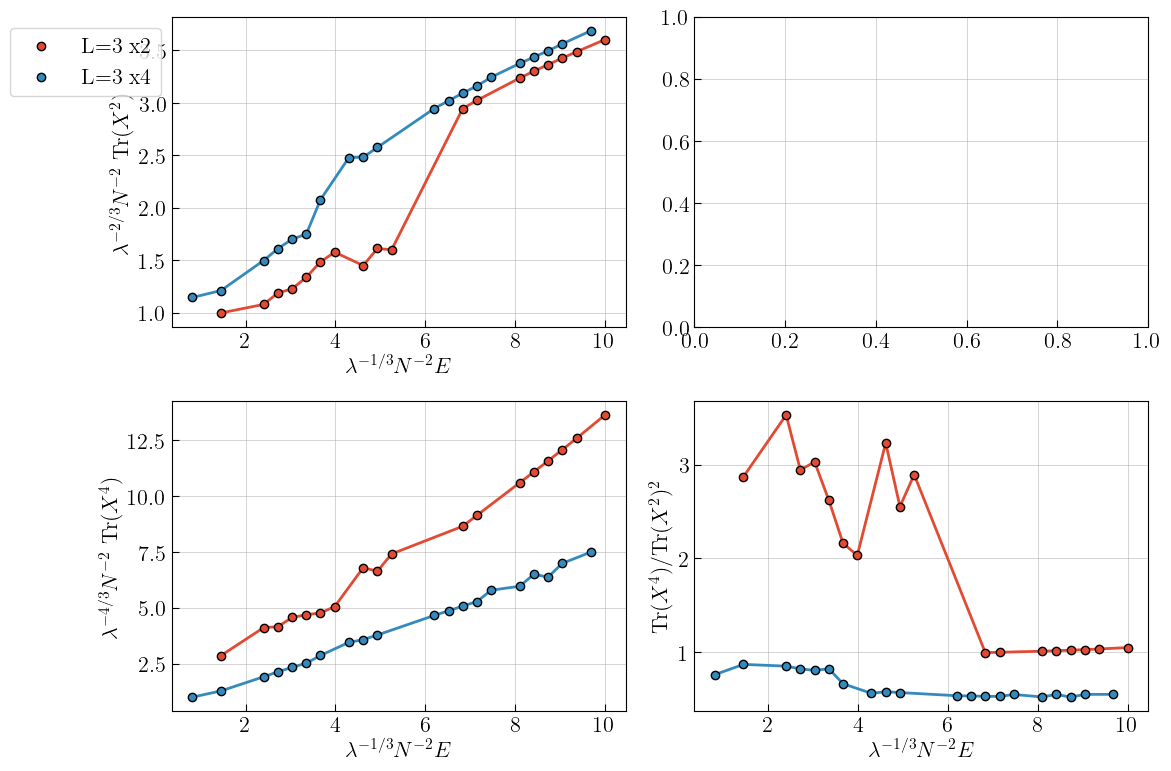

In [163]:
fig, axes = plt.subplots(2, 2, figsize=(2*6, 2*4))

ax = axes[0,0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4]):#, df_commutator]):
    ax.plot(df["energy"], df["x_2"])
    ax.scatter(df["energy"], df["x_2"], label='L=3 ' + name, edgecolor='k', zorder=10)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=16, bbox_to_anchor=(0,1))

ax = axes[1, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4]):#, df_commutator]):
    ax.plot(df["energy"], df["x_4"])
    ax.scatter(df["energy"], df["x_4"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")

ax = axes[1, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4]):#, df_commutator]):
    ax.plot(df["energy"], df["x_4"]/df["x_2"]**2)
    ax.scatter(df["energy"], df["x_4"]/df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"Tr$(X^4)$/Tr$(X^2)^2$")

'''
ax = axes[2, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"])
    ax.scatter(df["energy"], df["neg_commutator_squared"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-$\lambda^{-2/3} N^{-4}$ Tr$([X, Y]^2)$")

ax = axes[2, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2)
    ax.scatter(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")
'''

plt.tight_layout()
plt.show()

In [102]:
beta = get_beta_from_E_and_F(
    energy=df_x4["energy"],
    free_energy=-df_x4["p_2"]/2 + df_x4["neg_commutator_squared"]/4
    )
beta

array([1.        , 0.90556355, 0.83352147, 0.8152309 , 0.76337362])

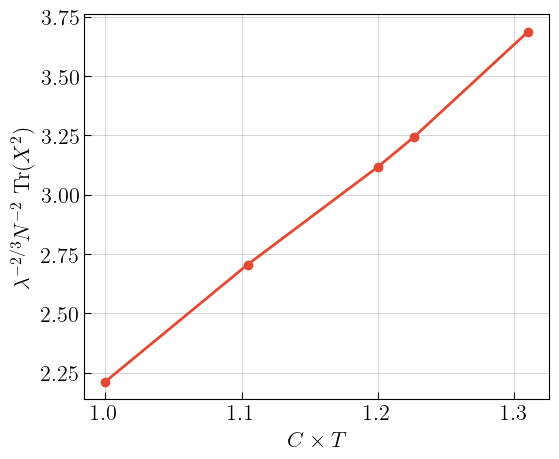

In [103]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(1/beta, df_x4["x_2"], '-o')
ax.set_xlabel(r"$C \times T$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
plt.show()

## BFSS

In [ ]:
df_berkowitz = pd.read_csv("data/data_from_papers/Berkowits et al 1606.04951.csv", header=0)
df_berkowitz

In [ ]:
def lin_lower_bound_x2(energy: float) -> float:
    # eq 2.18 and 2.19 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_19 = lambda v: energy**2 + 3**9 / (energy + 3 * v) - 9 * v**2
    sol = optimize.root(eq2_19, [0])
    v = sol.x.item()
    lower_bound = (energy - 3*v)**2 / (9**3 * 16) + 27 / (8 * (energy + 3 * v))
    return lower_bound

def lin_lower_bound_x4_bosonic_only(energy: float, d: int) -> float:
    return energy / (3 * d * (d-1))

def lin_lower_bound_x4_initial(energy: float, d: int) -> float:
    # eq 2.13 of https://doi.org/10.1007/JHEP06(2023)038
    # includes fermions in how the virial theorem is used
    # y is the bound
    eq2_13 = lambda y: np.sqrt(y) * (2*d*(d-1) * y + 2/3*energy) - d/4
    sol = optimize.root(eq2_13, [0])
    return sol.x.item()

def lin_lower_bound_x4_improved(energy: float) -> float:
    # eq 2.20 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # y is the bound
    eq2_20 = lambda y: (energy/9 + 24*y) * (144 * np.sqrt(y) - (energy/9 - 24*y)**2) - 54
    sol = optimize.root(eq2_20, [0])
    return sol.x.item()

def lin_upper_bound_commutator(energy: float) -> float:
    # TODO in progress!
    # eq 2.23 and 2.24 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_24 = lambda v: (energy - 3*v) * (energy + 3*v)**2 - 2*3**9
    eq2_23_RHS = lambda v: (v / 18) * ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** (-2)
    sol = optimize.minimize(eq2_24, [2])
    v = sol.x.item()
    #factor = ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** 2
    #lower_bound = (v / 18) / factor
    return eq2_23_RHS(v)

In [ ]:
df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)

df_x4 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_4'],
    tol=1e-4,
)

df_commutator = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'neg_commutator_squared'],
    tol=1e-4,
)

NOTE: 
- my quantities involve sum over i=1,2,3. Lin has no sum. Berkovits has a sum for i=1,...,9
- Berkowitz has rescaled the matrices by sqrt(N) relative to me
- Berkowitz has fermions

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(3*6, 3*5))

ax = axes[0,0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_2"])
    ax.scatter(df["energy"], df["x_2"], label='L=3 ' + name, edgecolor='k', zorder=10)
#lower_bound = 3 * np.asarray([lin_lower_bound_x2(e) for e in df_x2["energy"]])
#ax.plot(df_x2["energy"], lower_bound, '--', label='Lin')
ax.scatter(df_berkowitz["energy"], df_berkowitz["R squared"] / 3, label='Berkowitz (N=32)', edgecolor='k', zorder=10, color=colors[-1])
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_ylim([min(lower_bound), 1])
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))

ax = axes[1, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"])
    ax.scatter(df["energy"], df["x_4"], label='L=3 ' + name, edgecolor='k', zorder=10)

lower_bound = np.asarray([lin_lower_bound_x4_initial(e, d=3) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], lower_bound, '--', label='Lin (initial)')

lower_bound = np.asarray([lin_lower_bound_x4_bosonic_only(e, d=3) for e in df_x4["energy"]])
ax.plot(df_x4["energy"], lower_bound, '--', label='Lin (initial, bosonic only)')

#lower_bound = 3 * np.asarray([lin_lower_bound_x4_improved(e) for e in df_x4["energy"]])
#ax.plot(df_x4["energy"], 3 * lower_bound, '--', label='Lin (improved)')

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-2}$ Tr$(X^4)$")
ax.legend()

ax = axes[1, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["x_4"]/df["x_2"]**2)
    ax.scatter(df["energy"], df["x_4"]/df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"Tr$(X^4)$/Tr$(X^2)^2$")

ax = axes[2, 0]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"])
    ax.scatter(df["energy"], df["neg_commutator_squared"], label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-$\lambda^{-2/3} N^{-4}$ Tr$([X, Y]^2)$")

ax = axes[2, 1]
for name, df in zip(['x2', 'x4', 'commutator'], [df_x2, df_x4, df_commutator]):
    ax.plot(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2)
    ax.scatter(df["energy"], df["neg_commutator_squared"] / df["x_2"]**2, label='L=3 ' + name, edgecolor='k', zorder=10)
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"-Tr$([X, Y]^2)/$Tr$(X^2)^2$")

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric_transition",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='L=3', edgecolor='k', zorder=10)

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='L=3', edgecolor='k', zorder=10)


ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))
plt.show()

In [ ]:
df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric_transition",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4)

df_x2["energy"].to_numpy()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

df_x2 = load_data(
    datadir="data/MiniBFSS_L_3_symmetric",
    names_in_filename=['energy', 'x_2'],
    tol=1e-4,
)
ax.plot(df_x2["energy"], df_x2["x_2"])
ax.scatter(df_x2["energy"], df_x2["x_2"], label='E', edgecolor='k', zorder=10)

ax.plot(df_x2["energy"], df_x2["p_2"] - df_x2["neg_commutator_squared"] / 4)
ax.scatter(df_x2["energy"], df_x2["p_2"] - df_x2["neg_commutator_squared"] / 4, label='Free Energy', edgecolor='k', zorder=10)

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.legend(fontsize=12, bbox_to_anchor=(0,1))
plt.show()